# Library

In [80]:
import pandas as pd
import numpy as np
import random
import re
from numpy.random import randn
from numpy.random import randint
import keras
import tensorflow as tf
from time import time

In [47]:
#process intent
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Bidirectional

In [2]:
#data and layers
from sklearn.model_selection import train_test_split
from tensorflow.data import Dataset
from keras.models import Sequential
from keras import layers, Model
from keras.utils import to_categorical
from keras.layers import Conv2D, PReLU, BatchNormalization, Flatten, Dropout, Conv2DTranspose, Embedding, Reshape
from keras.layers import Concatenate, LeakyReLU, Dense, Input, add, UpSampling2D, Activation, multiply
from keras.optimizers import Adam

In [3]:
# Plot
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
%matplotlib inline

# Data

### Preprocesssing fashion mnist dataset

In [4]:
# Spilt and scale fashion mnist
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5

print("-------------------------------------------------")
X_train.shape,  y_train.shape, X_test.shape, y_test.shape

-------------------------------------------------


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
# Expand dims of data for containing no. of feature
X_train_expand = np.expand_dims(X_train, axis = -1)

X_test_expand = np.expand_dims(X_test, axis = -1)

X_train_expand.shape, y_train.shape, X_test_expand.shape, y_test.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

### Preprocessing Intent dataset for fashion mnist dataset

#### Import Intent dataset

In [49]:
import os
print(os.getcwd())


H:\TestCereBro


In [50]:
# https://github.com/hungnq1310/hero131a/Intent.csv
import pandas as pd

file_path = os.path.join(os.getcwd(), "Intent.csv")

data= pd.read_csv(file_path, header = None)
data[0:10]

,0
0,where I can find the T-shirt/top shop;T-shirt/top
1,How were the trousers made?;Trouser
2,I would like to find a list of cool things suc...
3,the main uses of these bags?;Bag
4,the name of the dress that a person wears to ...
5,What are the most popular sneakers in the worl...
6,the status on my shirt waranty;Shirt
7,Let's being fashion with the dress in the next...
8,Make the perfect Shirt for a Special Occasion;...
9,The best Pullover Tips That'll Keep You Warm o...


In [51]:
# Fail format so I start to process the column 0
data[0]=data[0].str.split(";")
data[0][1][1].strip()

'Trouser'

In [52]:
# Clean the database
data['intent'] = [data[0][i][1].strip() for i in range(0,len(data))]
data['query'] = [data[0][i][0] for i in range(0,len(data))]
data = data[['intent','query']]
data[0:10]

,intent,query
0,T-shirt/top,where I can find the T-shirt/top shop
1,Trouser,How were the trousers made?
2,Shirt,I would like to find a list of cool things suc...
3,Bag,the main uses of these bags?
4,Dress,the name of the dress that a person wears to ...
5,Sneaker,What are the most popular sneakers in the world?
6,Shirt,the status on my shirt waranty
7,Dress,Let's being fashion with the dress in the next...
8,Shirt,Make the perfect Shirt for a Special Occasion
9,Pullover,The best Pullover Tips That'll Keep You Warm o...


#### Preprocessing intent 

In [53]:
# Convert to list
entire_sents = list(data["query"])
entire_intents = list(data["intent"])

# Prepare Labels and for every sample, assign an unique category id to each intent in a new column in dataframe.

# This method is useful for obtaining a numeric representation of an array
data['category_id'] = data['intent'].factorize()[0] 
### create new columns               ### Like enumarate function

# create new table contains intent and category_id
category_id_df = data[['intent', 'category_id']].drop_duplicates().sort_values('category_id')
category_id_df

,intent,category_id
0,T-shirt/top,0
1,Trouser,1
2,Shirt,2
3,Bag,3
4,Dress,4
5,Sneaker,5
9,Pullover,6
10,ankle-boot,7
33,Coat,8
40,Sandal,9


In [54]:
# Figure some nescessary part for later uses.
category_to_id = dict(category_id_df.values) # return dict
id_to_category = dict(category_id_df[['category_id', 'intent']].values) # return dict
id_to_category

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Shirt',
 3: 'Bag',
 4: 'Dress',
 5: 'Sneaker',
 6: 'Pullover',
 7: 'ankle-boot',
 8: 'Coat',
 9: 'Sandal'}

#### Data cleaning

In [55]:
def cleaning(sents):
    words = []
    lemmatizer = WordNetLemmatizer() # return the basic form of words
    for sent in sents:
        # Remove anything that is not alphanumeric character
        cleaned_sent = re.sub(r'[^ a-z A-Z 0-9]', " ", sent)

        # Split sentence into chunks of words i.e. tokens
        word = nltk.tokenize.word_tokenize(cleaned_sent)
        
        # Lemmatize the tokens i.e. convert it to its dictionary form
        words.append([lemmatizer.lemmatize(w.lower()) for w in word])
        
    return words

In [56]:
# # The library of colab doesn't contain these libraries so I manually download it
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [57]:
# get the clean sentences of function cleaning
cleaned_entire_sents = cleaning(entire_sents)
for i in range(0,10):
  print(cleaned_entire_sents[i])

['where', 'i', 'can', 'find', 'the', 't', 'shirt', 'top', 'shop']
['how', 'were', 'the', 'trouser', 'made']
['i', 'would', 'like', 'to', 'find', 'a', 'list', 'of', 'cool', 'thing', 'such', 'a', 'nice', 'shirt']
['the', 'main', 'us', 'of', 'these', 'bag']
['the', 'name', 'of', 'the', 'dress', 'that', 'a', 'person', 'wear', 'to', 'work']
['what', 'are', 'the', 'most', 'popular', 'sneaker', 'in', 'the', 'world']
['the', 'status', 'on', 'my', 'shirt', 'waranty']
['let', 's', 'being', 'fashion', 'with', 'the', 'dress', 'in', 'the', 'next', '5', 'minute']
['make', 'the', 'perfect', 'shirt', 'for', 'a', 'special', 'occasion']
['the', 'best', 'pullover', 'tip', 'that', 'll', 'keep', 'you', 'warm', 'on', 'a', 'cold', 'winter', 'day']


#### Encode the intent input

In [58]:
def create_tokenizer(words, filters = '!"#$%&()}~\t\n'): 
  token = Tokenizer(filters = filters) # create token with specified filter
  token.fit_on_texts(words)
  return token

def max_length(words):
  return(len(max(words, key = len))) # return the longest sentences which have in dataset

def encoding_doc(token, words): # convert each word of sentence to specificed number, like Label_Encoder
  return(token.texts_to_sequences(words))

def padding_doc(encoded_doc, max_length): # pad 0 to sentence so each sentence of data have the same length
  return(keras.utils.pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))


In [59]:
word_tokenizer = create_tokenizer(cleaned_entire_sents) 
vocab_size = len(word_tokenizer.word_index) + 1 # number of vocabulary of token
# print(word_tokenizer.word_index)
max_length = max_length(cleaned_entire_sents)
print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 623 and Maximum length = 23


In [60]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_entire_sents) # encode the sentences
# print(encoded_doc)

padded_doc = padding_doc(encoded_doc, max_length) # pad [0] to the length of MAX_LENGTH 
print("Shape of padded docs = ",padded_doc.shape)

output_tokenizer = create_tokenizer(list(category_id_df['intent'])) # encode the intents
output_tokenizer.word_index

Shape of padded docs =  (449, 23)


{'t-shirt/top': 1,
 'trouser': 2,
 'shirt': 3,
 'bag': 4,
 'dress': 5,
 'sneaker': 6,
 'pullover': 7,
 'ankle-boot': 8,
 'coat': 9,
 'sandal': 10}

In [61]:
encoded_output = encoding_doc(output_tokenizer, entire_intents) # convert intent to coresponding number in tokenizer
# print(encoded_output)
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)
print(encoded_output.shape)

(449, 1)


In [62]:
def one_hot(encode):
  o = OneHotEncoder(sparse = False) # Like label_encoder
  return(o.fit_transform(encode))

output_one_hot = one_hot(encoded_output)
output_one_hot.shape # shape 10 is the max_length

(449, 10)

# Model

### Classify intent of input

In [75]:
# Rows 0 to 2400 corresponds to Training data
X_train_enconded = padded_doc[:350]
y_train_encoded = output_one_hot[:350]

# Rows 2400 to 3000 corresponds to Testing data
X_test_encoded = padded_doc[350:]
y_test_encoded = output_one_hot[350:]

In [76]:
def create_model_predict_intent(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False)) # turns positive integers (indexes) into dense vectors of fixed size.
  model.add(Bidirectional(LSTM(128))) # apply LSTM layer before Bidirectional Layer
#   model.add(LSTM(128))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation = "softmax"))
  
  return model

In [77]:
model_cnn_predict_intent = create_model_predict_intent(vocab_size, max_length)

model_cnn_predict_intent.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model_cnn_predict_intent.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 23, 128)           79744     
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense_8 (Dense)             (None, 32)                8224      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 10)                330       
                                                                 
Total params: 351,466
Trainable params: 271,722
Non-trainable params: 79,744
_____________________________________________

In [81]:
tensorboard_classify = TensorBoard(log_dir = "./Question4/logs/Model_cnn_intent_classifier/".format(time()))

# Give the tensorboard and train my CNN model
model_cnn_predict_intent.fit(X_train_enconded, y_train_encoded, epochs = 50, batch_size = 10 , callbacks = [tensorboard_classify])


Epoch 1/50
35/35 [==============================] - 8s 17ms/step - loss: 2.2824 - accuracy: 0.1514
Epoch 2/50
35/35 [==============================] - 0s 14ms/step - loss: 2.2721 - accuracy: 0.1343
Epoch 3/50
35/35 [==============================] - 0s 13ms/step - loss: 2.2528 - accuracy: 0.1286
Epoch 4/50
35/35 [==============================] - 0s 13ms/step - loss: 2.2392 - accuracy: 0.1543
Epoch 5/50
35/35 [==============================] - 0s 13ms/step - loss: 2.2063 - accuracy: 0.1571
Epoch 6/50
35/35 [==============================] - 0s 13ms/step - loss: 2.1425 - accuracy: 0.2343
Epoch 7/50
35/35 [==============================] - 0s 13ms/step - loss: 2.0216 - accuracy: 0.2657
Epoch 8/50
35/35 [==============================] - 0s 14ms/step - loss: 1.8920 - accuracy: 0.3400
Epoch 9/50
35/35 [==============================] - 0s 13ms/step - loss: 1.7302 - accuracy: 0.3857
Epoch 10/50
35/35 [==============================] - 0s 12ms/step - loss: 1.6626 - accuracy: 0.4400
Epoch 11/

In [82]:
# Saved model

model_cnn_predict_intent.save(os.path.join('Saved Models', 'Question4', 'CNN_predict_model'))

INFO:tensorflow:Assets written to: Saved Models\Question4\CNN_predict_model\assets


INFO:tensorflow:Assets written to: Saved Models\Question4\CNN_predict_model\assets


### Cluster dataset model

In [63]:
category_id_df

,intent,category_id
0,T-shirt/top,0
1,Trouser,1
2,Shirt,2
3,Bag,3
4,Dress,4
5,Sneaker,5
9,Pullover,6
10,ankle-boot,7
33,Coat,8
40,Sandal,9


Create a model that cluster the fashion_mnist dataset

##### Using CNN model

In [ ]:
# def create_model_clustering_data():
#     return tf.keras.Sequential([
#             tf.keras.layers.Conv2D(32, (3,3),input_shape=(28,28,1),padding = "same"),
#             tf.keras.layers.Conv2D(64, (3,3),padding = "same"),
#             tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
#             tf.keras.layers.Dropout(.25),
#             tf.keras.layers.Flatten(),
#             tf.keras.layers.Dense(128, activation='relu'),
#             tf.keras.layers.Dropout(.5),
#             tf.keras.layers.Dense(10, activation = 'softmax')])
    
# model_cnn_clustering = create_model_clustering_intent()
# model_cnn_clustering.summary()

In [ ]:
# model_cnn_clustering.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# tensorboard_cluster = TensorBoard(log_dir = ".Question4/logs/Model_cnn_clustering_intent/".format(time()))

# # extend dim for CNN
# X_train_expand = np.expand_dims(X_train, axis=-1)
# X_test_expand = np.expand_dims(X_test, axis=-1)
# X_train_expand.shape, X_test_expand.shape

# # Training
# model_cnn_clustering.fit(X_train_expand, y_train, epochs=10, batch_size = 60, callbacks = [tensorboard_cluster])

# label_image_predict = model_cnn_clustering.predict(X_test_expand)

# # label_image_predict = len(model_cnn_clustering)
# label_image_predict

In [ ]:
# # Convert label_img_pred to shape(10000,1)
# for n in range(0,len(label_image_predict)):
#   label_image_predict[n] = np.argmax(label_image_predict[n])

# # get the first columns of label_image_predict
# label_hat = label_image_predict[:,1]
# cluster_indexes = get_numof_each_cluster(label_hat)
# cluster_indexes[5][100] # the index of image belong to cluster 5

##### Using K-means

In [64]:
def get_numof_each_cluster(labels):
  num_cluster_labels = len(np.unique(labels)) # 10 labels with corresponding types

  # empty list
  cluster_indexes = [[] for i in range(num_cluster_labels)] 
  #print(cluster_indexes)

  for i,label in enumerate(labels):
      for n in range(num_cluster_labels):
          if label == n:
              cluster_indexes[n].append(i)
          else:
              continue
  for i in range(num_cluster_labels):
    print('No. of items in Cluster ' + str(i) + ': ' + str(len(cluster_indexes[i])))            
  return cluster_indexes

In [65]:
# Flatten datasets
X_train_flat = X_train.reshape(60000, 784)

# I only use one X_train to train k-means model and get the labels but not using the X_test in that model

In [66]:
# Using k-means with pre-specified number of clusters
from sklearn.cluster import KMeans

kmeans = KMeans(init = 'k-means++', n_clusters = 10, n_init = 10, max_iter = 1000)
kmeans.fit(X_train_flat)

KMeans(max_iter=1000, n_clusters=10)

In [67]:
labels = kmeans.labels_
labels.shape

(60000,)

In [68]:
cluster_of_kmean = get_numof_each_cluster(labels)

No. of items in Cluster 0: 7533
No. of items in Cluster 1: 5819
No. of items in Cluster 2: 5231
No. of items in Cluster 3: 2545
No. of items in Cluster 4: 7750
No. of items in Cluster 5: 2361
No. of items in Cluster 6: 3707
No. of items in Cluster 7: 9717
No. of items in Cluster 8: 7779
No. of items in Cluster 9: 7558


### Create extracting feature model like VGG

First time, I use the simple custom model to extract the pattern and using it for replacing the noise of generator because the idea of using image's pattern can highly be convinient for generator. However, the result is bad because the generator completely break the input image without convert it to original image.

In [ ]:
# def extract_feature_model():
#     extract_model = Sequential()
#     extract_model.add(Input(shape = (28,28)))
#     extract_model.add(Flatten())
#     extract_model.add(Dense(1024, activation='relu'))
#     extract_model.add(Dense(784))
#     return extract_model


In [ ]:
# # Create model
# extract_model = extract_feature_model()
# extract_model.summary()

Not train anymore because the goal is convert image to something like noise

In [ ]:
# image = X_train[200]

# prd_image = extract_model.predict(image.reshape(1,28,28))  

# plt.imshow(prd_image.reshape(28,28))
# plt.plot()

###### create a custom kernel_intializer

In [ ]:
# Custom the kernel_initializer based on SOBEL filter in edge_detection.
def kernelInitializer(shape, dtype=None): 
    # print(shape)    
    sobel_x = tf.constant(
        [
            [-5, -4, 0, 4, 5], 
            [-8, -10, 0, 10, 8], 
            [-10, -20, 0, 20, 10], 
            [-8, -10, 0, 10, 8], 
            [-5, -4, 0, 4, 5]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (5, 5, 1, 1))

    # print(tf.shape(sobel_x)) (5, 5, 1, 1)
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    # print(tf.shape(sobel_x)) # tf.Tensor([5 5 1 1], shape=(4,), dtype=int32)
    return sobel_x

In [ ]:
# this function will combine edge detection from Sobel filter and random noise. This random noise image will ensure the generator will create image random instead of fixed style

def get_edge_image():
  edge_decect_model = Sequential()
  edge_decect_model.add(Input((28,28,1)))
  edge_decect_model.add(Conv2D(1, kernel_size = (5,5), padding = 'same', kernel_initializer=kernelInitializer, strides = 1, activation='relu'))
  return edge_decect_model


In [ ]:
edge_detect_model = get_edge_image()
edge_detect_model.summary()

### Model GAN

##### get image

In [ ]:
# for each 1000 epoch, I will using sample_images function to temporarily visualizing the ouput image
def sample_images(epoch, extr_model, generator, z_dim = (28, 28, 1), save_output=True):

    r, c = 5, 5

    noise = extr_model.predict(X_train[r*c])
    gen_imgs = generator.predict(noise.reshape((28,28,1)))

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    # get output shape
    output_shape = len(generator.output_shape)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            if output_shape == 3:
                axs[i, j].imshow(gen_imgs[cnt, :, :], cmap='gray')
            else:
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')

            axs[i, j].axis('off')
            cnt += 1
    plt.show()

    plt.close()

##### Conditional GAN 

In [6]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(32, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model


In [7]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(64, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [8]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


In [9]:
# # select real samples
def generate_real_samples(train_data, label_data, n_samples):

    # choose random instances
    ix = randint(0, train_data.shape[0], n_samples)
    
    # select images and labels
    X, labels = train_data[ix], label_data[ix]
    
    # generate class labels
    y = np.ones((n_samples, 1))
    return [X, labels], y

In [10]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]


In [11]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator_model, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator_model.predict([z_input, labels_input])
    # create class labels
    y = np.zeros((n_samples, 1))
    return [images, labels_input], y


In [17]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
# train model

In [27]:
n_batch = 60
n_epochs = 100

bat_per_epo = int(X_train.shape[0] / n_batch)
half_batch = int(n_batch / 2)
# manually enumerate epochs
for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(X_train, y_train, half_batch)
        # update discriminator model weights
        d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
        # generate 'fake' examples
        [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
        # prepare points in latent space as input for the generator
        [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
        # summarize loss on this batch
        print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
            (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
# save the generator model



1/1 [==============================] - 0s 39ms/step
>1, 1/1000, d1=0.545, d2=0.691 g=0.743
1/1 [==============================] - 0s 32ms/step
>1, 2/1000, d1=0.582, d2=0.809 g=0.744
1/1 [==============================] - 0s 39ms/step
>1, 3/1000, d1=0.569, d2=0.715 g=0.761
1/1 [==============================] - 0s 42ms/step
>1, 4/1000, d1=0.581, d2=0.725 g=0.766
1/1 [==============================] - 0s 34ms/step
>1, 5/1000, d1=0.617, d2=0.658 g=0.780
1/1 [==============================] - 0s 35ms/step
>1, 6/1000, d1=0.684, d2=0.663 g=0.833
1/1 [==============================] - 0s 41ms/step
>1, 7/1000, d1=0.580, d2=0.676 g=0.798
1/1 [==============================] - 0s 34ms/step
>1, 8/1000, d1=0.705, d2=0.700 g=0.828
1/1 [==============================] - 0s 41ms/step
>1, 9/1000, d1=0.632, d2=0.631 g=0.831
1/1 [==============================] - 0s 34ms/step
>1, 10/1000, d1=0.600, d2=0.592 g=0.871
1/1 [==============================] - 0s 36ms/step
>1, 11/1000, d1=0.690, d2=0.673 g=0.8

1/1 [==============================] - 0s 32ms/step
>1, 90/1000, d1=0.641, d2=0.630 g=0.884
1/1 [==============================] - 0s 36ms/step
>1, 91/1000, d1=0.692, d2=0.670 g=0.823
1/1 [==============================] - 0s 44ms/step
>1, 92/1000, d1=0.647, d2=0.631 g=0.808
1/1 [==============================] - 0s 35ms/step
>1, 93/1000, d1=0.626, d2=0.681 g=0.819
1/1 [==============================] - 0s 35ms/step
>1, 94/1000, d1=0.645, d2=0.682 g=0.813
1/1 [==============================] - 0s 43ms/step
>1, 95/1000, d1=0.656, d2=0.602 g=0.841
1/1 [==============================] - 0s 35ms/step
>1, 96/1000, d1=0.561, d2=0.742 g=0.826
1/1 [==============================] - 0s 35ms/step
>1, 97/1000, d1=0.624, d2=0.666 g=0.827
1/1 [==============================] - 0s 37ms/step
>1, 98/1000, d1=0.695, d2=0.651 g=0.936
1/1 [==============================] - 0s 35ms/step
>1, 99/1000, d1=0.701, d2=0.559 g=0.903
1/1 [==============================] - 0s 32ms/step
>1, 100/1000, d1=0.863, d2=0

1/1 [==============================] - 0s 32ms/step
>1, 178/1000, d1=0.624, d2=0.650 g=0.921
1/1 [==============================] - 0s 34ms/step
>1, 179/1000, d1=0.589, d2=0.608 g=0.883
1/1 [==============================] - 0s 37ms/step
>1, 180/1000, d1=0.740, d2=0.608 g=0.874
1/1 [==============================] - 0s 37ms/step
>1, 181/1000, d1=0.666, d2=0.657 g=0.815
1/1 [==============================] - 0s 33ms/step
>1, 182/1000, d1=0.639, d2=0.680 g=0.867
1/1 [==============================] - 0s 33ms/step
>1, 183/1000, d1=0.543, d2=0.650 g=0.874
1/1 [==============================] - 0s 33ms/step
>1, 184/1000, d1=0.652, d2=0.617 g=0.880
1/1 [==============================] - 0s 33ms/step
>1, 185/1000, d1=0.602, d2=0.683 g=0.835
1/1 [==============================] - 0s 37ms/step
>1, 186/1000, d1=0.629, d2=0.574 g=0.915
1/1 [==============================] - 0s 32ms/step
>1, 187/1000, d1=0.697, d2=0.612 g=0.831
1/1 [==============================] - 0s 34ms/step
>1, 188/1000, d1=0

1/1 [==============================] - 0s 35ms/step
>1, 266/1000, d1=0.608, d2=0.649 g=0.790
1/1 [==============================] - 0s 40ms/step
>1, 267/1000, d1=0.606, d2=0.592 g=0.902
1/1 [==============================] - 0s 33ms/step
>1, 268/1000, d1=0.628, d2=0.662 g=0.896
1/1 [==============================] - 0s 37ms/step
>1, 269/1000, d1=0.617, d2=0.631 g=0.887
1/1 [==============================] - 0s 32ms/step
>1, 270/1000, d1=0.638, d2=0.622 g=0.852
1/1 [==============================] - 0s 34ms/step
>1, 271/1000, d1=0.540, d2=0.595 g=0.863
1/1 [==============================] - 0s 32ms/step
>1, 272/1000, d1=0.687, d2=0.576 g=0.827
1/1 [==============================] - 0s 32ms/step
>1, 273/1000, d1=0.641, d2=0.627 g=0.830
1/1 [==============================] - 0s 33ms/step
>1, 274/1000, d1=0.740, d2=0.626 g=0.868
1/1 [==============================] - 0s 36ms/step
>1, 275/1000, d1=0.639, d2=0.610 g=0.859
1/1 [==============================] - 0s 37ms/step
>1, 276/1000, d1=0

1/1 [==============================] - 0s 36ms/step
>1, 354/1000, d1=0.666, d2=0.596 g=0.868
1/1 [==============================] - 0s 34ms/step
>1, 355/1000, d1=0.586, d2=0.638 g=0.827
1/1 [==============================] - 0s 33ms/step
>1, 356/1000, d1=0.626, d2=0.588 g=0.855
1/1 [==============================] - 0s 33ms/step
>1, 357/1000, d1=0.650, d2=0.630 g=0.749
1/1 [==============================] - 0s 39ms/step
>1, 358/1000, d1=0.639, d2=0.678 g=0.816
1/1 [==============================] - 0s 34ms/step
>1, 359/1000, d1=0.585, d2=0.677 g=0.839
1/1 [==============================] - 0s 34ms/step
>1, 360/1000, d1=0.727, d2=0.623 g=0.822
1/1 [==============================] - 0s 32ms/step
>1, 361/1000, d1=0.608, d2=0.686 g=0.838
1/1 [==============================] - 0s 40ms/step
>1, 362/1000, d1=0.646, d2=0.711 g=0.857
1/1 [==============================] - 0s 32ms/step
>1, 363/1000, d1=0.662, d2=0.685 g=0.836
1/1 [==============================] - 0s 35ms/step
>1, 364/1000, d1=0

1/1 [==============================] - 0s 37ms/step
>1, 442/1000, d1=0.604, d2=0.716 g=0.849
1/1 [==============================] - 0s 37ms/step
>1, 443/1000, d1=0.688, d2=0.610 g=0.892
1/1 [==============================] - 0s 39ms/step
>1, 444/1000, d1=0.707, d2=0.663 g=0.938
1/1 [==============================] - 0s 41ms/step
>1, 445/1000, d1=0.752, d2=0.587 g=0.872
1/1 [==============================] - 0s 43ms/step
>1, 446/1000, d1=0.660, d2=0.661 g=0.898
1/1 [==============================] - 0s 42ms/step
>1, 447/1000, d1=0.686, d2=0.652 g=0.838
1/1 [==============================] - 0s 40ms/step
>1, 448/1000, d1=0.611, d2=0.590 g=0.794
1/1 [==============================] - 0s 37ms/step
>1, 449/1000, d1=0.606, d2=0.645 g=0.866
1/1 [==============================] - 0s 36ms/step
>1, 450/1000, d1=0.690, d2=0.631 g=0.875
1/1 [==============================] - 0s 36ms/step
>1, 451/1000, d1=0.626, d2=0.637 g=0.806
1/1 [==============================] - 0s 36ms/step
>1, 452/1000, d1=0

1/1 [==============================] - 0s 44ms/step
>1, 530/1000, d1=0.572, d2=0.642 g=0.891
1/1 [==============================] - 0s 33ms/step
>1, 531/1000, d1=0.678, d2=0.635 g=0.857
1/1 [==============================] - 0s 36ms/step
>1, 532/1000, d1=0.618, d2=0.619 g=0.820
1/1 [==============================] - 0s 43ms/step
>1, 533/1000, d1=0.613, d2=0.628 g=0.793
1/1 [==============================] - 0s 34ms/step
>1, 534/1000, d1=0.629, d2=0.576 g=0.866
1/1 [==============================] - 0s 33ms/step
>1, 535/1000, d1=0.581, d2=0.661 g=0.872
1/1 [==============================] - 0s 33ms/step
>1, 536/1000, d1=0.674, d2=0.624 g=0.851
1/1 [==============================] - 0s 34ms/step
>1, 537/1000, d1=0.658, d2=0.643 g=0.832
1/1 [==============================] - 0s 34ms/step
>1, 538/1000, d1=0.640, d2=0.561 g=0.845
1/1 [==============================] - 0s 34ms/step
>1, 539/1000, d1=0.530, d2=0.626 g=0.892
1/1 [==============================] - 0s 35ms/step
>1, 540/1000, d1=0

1/1 [==============================] - 0s 33ms/step
>1, 618/1000, d1=0.601, d2=0.612 g=0.869
1/1 [==============================] - 0s 32ms/step
>1, 619/1000, d1=0.611, d2=0.624 g=0.861
1/1 [==============================] - 0s 39ms/step
>1, 620/1000, d1=0.674, d2=0.637 g=0.835
1/1 [==============================] - 0s 33ms/step
>1, 621/1000, d1=0.585, d2=0.685 g=0.874
1/1 [==============================] - 0s 34ms/step
>1, 622/1000, d1=0.621, d2=0.650 g=0.820
1/1 [==============================] - 0s 33ms/step
>1, 623/1000, d1=0.672, d2=0.606 g=0.891
1/1 [==============================] - 0s 39ms/step
>1, 624/1000, d1=0.713, d2=0.613 g=0.835
1/1 [==============================] - 0s 32ms/step
>1, 625/1000, d1=0.687, d2=0.643 g=0.845
1/1 [==============================] - 0s 33ms/step
>1, 626/1000, d1=0.774, d2=0.643 g=0.810
1/1 [==============================] - 0s 35ms/step
>1, 627/1000, d1=0.683, d2=0.625 g=0.900
1/1 [==============================] - 0s 35ms/step
>1, 628/1000, d1=0

1/1 [==============================] - 0s 35ms/step
>1, 706/1000, d1=0.637, d2=0.645 g=0.824
1/1 [==============================] - 0s 34ms/step
>1, 707/1000, d1=0.627, d2=0.744 g=0.839
1/1 [==============================] - 0s 33ms/step
>1, 708/1000, d1=0.609, d2=0.662 g=0.816
1/1 [==============================] - 0s 34ms/step
>1, 709/1000, d1=0.603, d2=0.616 g=0.863
1/1 [==============================] - 0s 33ms/step
>1, 710/1000, d1=0.657, d2=0.661 g=0.835
1/1 [==============================] - 0s 34ms/step
>1, 711/1000, d1=0.649, d2=0.648 g=0.869
1/1 [==============================] - 0s 33ms/step
>1, 712/1000, d1=0.710, d2=0.613 g=0.913
1/1 [==============================] - 0s 36ms/step
>1, 713/1000, d1=0.712, d2=0.567 g=0.885
1/1 [==============================] - 0s 34ms/step
>1, 714/1000, d1=0.686, d2=0.651 g=0.856
1/1 [==============================] - 0s 33ms/step
>1, 715/1000, d1=0.708, d2=0.662 g=0.824
1/1 [==============================] - 0s 35ms/step
>1, 716/1000, d1=0

1/1 [==============================] - 0s 35ms/step
>1, 794/1000, d1=0.600, d2=0.647 g=0.847
1/1 [==============================] - 0s 35ms/step
>1, 795/1000, d1=0.658, d2=0.598 g=0.856
1/1 [==============================] - 0s 39ms/step
>1, 796/1000, d1=0.716, d2=0.706 g=0.885
1/1 [==============================] - 0s 35ms/step
>1, 797/1000, d1=0.572, d2=0.634 g=0.845
1/1 [==============================] - 0s 38ms/step
>1, 798/1000, d1=0.681, d2=0.639 g=0.878
1/1 [==============================] - 0s 36ms/step
>1, 799/1000, d1=0.730, d2=0.647 g=0.827
1/1 [==============================] - 0s 34ms/step
>1, 800/1000, d1=0.666, d2=0.653 g=0.812
1/1 [==============================] - 0s 45ms/step
>1, 801/1000, d1=0.643, d2=0.621 g=0.801
1/1 [==============================] - 0s 35ms/step
>1, 802/1000, d1=0.773, d2=0.694 g=0.822
1/1 [==============================] - 0s 33ms/step
>1, 803/1000, d1=0.588, d2=0.663 g=0.836
1/1 [==============================] - 0s 35ms/step
>1, 804/1000, d1=0

1/1 [==============================] - 0s 34ms/step
>1, 882/1000, d1=0.672, d2=0.617 g=0.901
1/1 [==============================] - 0s 42ms/step
>1, 883/1000, d1=0.703, d2=0.776 g=0.859
1/1 [==============================] - 0s 35ms/step
>1, 884/1000, d1=0.692, d2=0.690 g=0.850
1/1 [==============================] - 0s 34ms/step
>1, 885/1000, d1=0.689, d2=0.589 g=0.874
1/1 [==============================] - 0s 40ms/step
>1, 886/1000, d1=0.651, d2=0.552 g=0.975
1/1 [==============================] - 0s 34ms/step
>1, 887/1000, d1=0.654, d2=0.573 g=0.861
1/1 [==============================] - 0s 35ms/step
>1, 888/1000, d1=0.649, d2=0.650 g=0.849
1/1 [==============================] - 0s 36ms/step
>1, 889/1000, d1=0.724, d2=0.708 g=0.740
1/1 [==============================] - 0s 36ms/step
>1, 890/1000, d1=0.653, d2=0.675 g=0.921
1/1 [==============================] - 0s 33ms/step
>1, 891/1000, d1=0.656, d2=0.649 g=0.908
1/1 [==============================] - 0s 45ms/step
>1, 892/1000, d1=0

1/1 [==============================] - 0s 35ms/step
>1, 970/1000, d1=0.672, d2=0.643 g=0.829
1/1 [==============================] - 0s 34ms/step
>1, 971/1000, d1=0.643, d2=0.617 g=0.773
1/1 [==============================] - 0s 41ms/step
>1, 972/1000, d1=0.591, d2=0.712 g=0.793
1/1 [==============================] - 0s 32ms/step
>1, 973/1000, d1=0.648, d2=0.683 g=0.858
1/1 [==============================] - 0s 44ms/step
>1, 974/1000, d1=0.675, d2=0.669 g=0.876
1/1 [==============================] - 0s 37ms/step
>1, 975/1000, d1=0.676, d2=0.670 g=0.833
1/1 [==============================] - 0s 35ms/step
>1, 976/1000, d1=0.700, d2=0.669 g=0.814
1/1 [==============================] - 0s 31ms/step
>1, 977/1000, d1=0.685, d2=0.634 g=0.845
1/1 [==============================] - 0s 32ms/step
>1, 978/1000, d1=0.684, d2=0.636 g=0.830
1/1 [==============================] - 0s 36ms/step
>1, 979/1000, d1=0.641, d2=0.600 g=0.846
1/1 [==============================] - 0s 33ms/step
>1, 980/1000, d1=0

1/1 [==============================] - 0s 34ms/step
>2, 59/1000, d1=0.596, d2=0.632 g=0.928
1/1 [==============================] - 0s 34ms/step
>2, 60/1000, d1=0.709, d2=0.742 g=0.834
1/1 [==============================] - 0s 37ms/step
>2, 61/1000, d1=0.648, d2=0.662 g=0.723
1/1 [==============================] - 0s 35ms/step
>2, 62/1000, d1=0.607, d2=0.661 g=0.915
1/1 [==============================] - 0s 36ms/step
>2, 63/1000, d1=0.689, d2=0.694 g=0.953
1/1 [==============================] - 0s 33ms/step
>2, 64/1000, d1=0.631, d2=0.558 g=1.106
1/1 [==============================] - 0s 36ms/step
>2, 65/1000, d1=0.648, d2=0.593 g=1.033
1/1 [==============================] - 0s 35ms/step
>2, 66/1000, d1=0.671, d2=0.768 g=0.863
1/1 [==============================] - 0s 39ms/step
>2, 67/1000, d1=0.682, d2=0.727 g=0.811
1/1 [==============================] - 0s 45ms/step
>2, 68/1000, d1=0.629, d2=0.609 g=0.917
1/1 [==============================] - 0s 32ms/step
>2, 69/1000, d1=0.628, d2=0.

>2, 147/1000, d1=0.665, d2=0.667 g=0.847
1/1 [==============================] - 0s 34ms/step
>2, 148/1000, d1=0.687, d2=0.657 g=0.853
1/1 [==============================] - 0s 32ms/step
>2, 149/1000, d1=0.670, d2=0.727 g=0.865
1/1 [==============================] - 0s 34ms/step
>2, 150/1000, d1=0.648, d2=0.684 g=0.814
1/1 [==============================] - 0s 36ms/step
>2, 151/1000, d1=0.609, d2=0.653 g=0.930
1/1 [==============================] - 0s 34ms/step
>2, 152/1000, d1=0.640, d2=0.646 g=0.975
1/1 [==============================] - 0s 37ms/step
>2, 153/1000, d1=0.669, d2=0.608 g=0.862
1/1 [==============================] - 0s 32ms/step
>2, 154/1000, d1=0.709, d2=0.630 g=0.872
1/1 [==============================] - 0s 35ms/step
>2, 155/1000, d1=0.737, d2=0.647 g=0.852
1/1 [==============================] - 0s 34ms/step
>2, 156/1000, d1=0.646, d2=0.653 g=0.863
1/1 [==============================] - 0s 35ms/step
>2, 157/1000, d1=0.667, d2=0.576 g=0.854
1/1 [========================

1/1 [==============================] - 0s 33ms/step
>2, 236/1000, d1=0.642, d2=0.674 g=0.814
1/1 [==============================] - 0s 39ms/step
>2, 237/1000, d1=0.646, d2=0.714 g=0.863
1/1 [==============================] - 0s 34ms/step
>2, 238/1000, d1=0.662, d2=0.613 g=0.851
1/1 [==============================] - 0s 43ms/step
>2, 239/1000, d1=0.697, d2=0.792 g=0.792
1/1 [==============================] - 0s 36ms/step
>2, 240/1000, d1=0.635, d2=0.699 g=0.850
1/1 [==============================] - 0s 35ms/step
>2, 241/1000, d1=0.710, d2=0.647 g=0.881
1/1 [==============================] - 0s 35ms/step
>2, 242/1000, d1=0.646, d2=0.587 g=0.942
1/1 [==============================] - 0s 36ms/step
>2, 243/1000, d1=0.674, d2=0.652 g=0.877
1/1 [==============================] - 0s 35ms/step
>2, 244/1000, d1=0.724, d2=0.627 g=0.867
1/1 [==============================] - 0s 34ms/step
>2, 245/1000, d1=0.706, d2=0.672 g=0.876
1/1 [==============================] - 0s 35ms/step
>2, 246/1000, d1=0

1/1 [==============================] - 0s 39ms/step
>2, 324/1000, d1=0.644, d2=0.629 g=0.885
1/1 [==============================] - 0s 33ms/step
>2, 325/1000, d1=0.632, d2=0.600 g=0.884
1/1 [==============================] - 0s 31ms/step
>2, 326/1000, d1=0.709, d2=0.663 g=0.901
1/1 [==============================] - 0s 33ms/step
>2, 327/1000, d1=0.633, d2=0.606 g=0.841
1/1 [==============================] - 0s 44ms/step
>2, 328/1000, d1=0.695, d2=0.659 g=0.901
1/1 [==============================] - 0s 32ms/step
>2, 329/1000, d1=0.675, d2=0.585 g=0.870
1/1 [==============================] - 0s 33ms/step
>2, 330/1000, d1=0.739, d2=0.595 g=0.851
1/1 [==============================] - 0s 33ms/step
>2, 331/1000, d1=0.595, d2=0.626 g=0.779
1/1 [==============================] - 0s 38ms/step
>2, 332/1000, d1=0.607, d2=0.669 g=0.786
1/1 [==============================] - 0s 34ms/step
>2, 333/1000, d1=0.682, d2=0.638 g=0.883
1/1 [==============================] - 0s 35ms/step
>2, 334/1000, d1=0

1/1 [==============================] - 0s 34ms/step
>2, 412/1000, d1=0.753, d2=0.567 g=0.852
1/1 [==============================] - 0s 37ms/step
>2, 413/1000, d1=0.683, d2=0.648 g=0.858
1/1 [==============================] - 0s 35ms/step
>2, 414/1000, d1=0.696, d2=0.631 g=0.855
1/1 [==============================] - 0s 46ms/step
>2, 415/1000, d1=0.608, d2=0.679 g=0.817
1/1 [==============================] - 0s 32ms/step
>2, 416/1000, d1=0.629, d2=0.696 g=0.773
1/1 [==============================] - 0s 39ms/step
>2, 417/1000, d1=0.602, d2=0.709 g=0.853
1/1 [==============================] - 0s 33ms/step
>2, 418/1000, d1=0.753, d2=0.634 g=0.813
1/1 [==============================] - 0s 39ms/step
>2, 419/1000, d1=0.630, d2=0.621 g=0.889
1/1 [==============================] - 0s 33ms/step
>2, 420/1000, d1=0.633, d2=0.587 g=0.843
1/1 [==============================] - 0s 35ms/step
>2, 421/1000, d1=0.641, d2=0.620 g=0.846
1/1 [==============================] - 0s 31ms/step
>2, 422/1000, d1=0

1/1 [==============================] - 0s 33ms/step
>2, 500/1000, d1=0.682, d2=0.633 g=0.833
1/1 [==============================] - 0s 36ms/step
>2, 501/1000, d1=0.749, d2=0.628 g=0.884
1/1 [==============================] - 0s 36ms/step
>2, 502/1000, d1=0.659, d2=0.649 g=0.897
1/1 [==============================] - 0s 34ms/step
>2, 503/1000, d1=0.689, d2=0.660 g=0.827
1/1 [==============================] - 0s 37ms/step
>2, 504/1000, d1=0.575, d2=0.666 g=0.805
1/1 [==============================] - 0s 34ms/step
>2, 505/1000, d1=0.688, d2=0.605 g=0.810
1/1 [==============================] - 0s 44ms/step
>2, 506/1000, d1=0.668, d2=0.649 g=0.906
1/1 [==============================] - 0s 40ms/step
>2, 507/1000, d1=0.670, d2=0.573 g=0.903
1/1 [==============================] - 0s 35ms/step
>2, 508/1000, d1=0.622, d2=0.634 g=0.865
1/1 [==============================] - 0s 33ms/step
>2, 509/1000, d1=0.688, d2=0.735 g=0.845
1/1 [==============================] - 0s 35ms/step
>2, 510/1000, d1=0

1/1 [==============================] - 0s 38ms/step
>2, 588/1000, d1=0.630, d2=0.690 g=0.905
1/1 [==============================] - 0s 37ms/step
>2, 589/1000, d1=0.714, d2=0.628 g=0.853
1/1 [==============================] - 0s 35ms/step
>2, 590/1000, d1=0.697, d2=0.607 g=0.936
1/1 [==============================] - 0s 33ms/step
>2, 591/1000, d1=0.705, d2=0.576 g=0.905
1/1 [==============================] - 0s 37ms/step
>2, 592/1000, d1=0.696, d2=0.604 g=0.871
1/1 [==============================] - 0s 34ms/step
>2, 593/1000, d1=0.677, d2=0.728 g=0.806
1/1 [==============================] - 0s 35ms/step
>2, 594/1000, d1=0.644, d2=0.647 g=0.826
1/1 [==============================] - 0s 35ms/step
>2, 595/1000, d1=0.653, d2=0.619 g=0.824
1/1 [==============================] - 0s 39ms/step
>2, 596/1000, d1=0.622, d2=0.636 g=0.840
1/1 [==============================] - 0s 34ms/step
>2, 597/1000, d1=0.652, d2=0.620 g=0.879
1/1 [==============================] - 0s 43ms/step
>2, 598/1000, d1=0

1/1 [==============================] - 0s 33ms/step
>2, 676/1000, d1=0.556, d2=0.685 g=0.829
1/1 [==============================] - 0s 36ms/step
>2, 677/1000, d1=0.589, d2=0.579 g=0.870
1/1 [==============================] - 0s 38ms/step
>2, 678/1000, d1=0.623, d2=0.569 g=0.878
1/1 [==============================] - 0s 34ms/step
>2, 679/1000, d1=0.702, d2=0.655 g=0.862
1/1 [==============================] - 0s 36ms/step
>2, 680/1000, d1=0.683, d2=0.639 g=0.884
1/1 [==============================] - 0s 35ms/step
>2, 681/1000, d1=0.691, d2=0.704 g=0.843
1/1 [==============================] - 0s 37ms/step
>2, 682/1000, d1=0.615, d2=0.627 g=0.802
1/1 [==============================] - 0s 48ms/step
>2, 683/1000, d1=0.719, d2=0.658 g=0.791
1/1 [==============================] - 0s 38ms/step
>2, 684/1000, d1=0.726, d2=0.712 g=0.815
1/1 [==============================] - 0s 37ms/step
>2, 685/1000, d1=0.638, d2=0.651 g=0.835
1/1 [==============================] - 0s 39ms/step
>2, 686/1000, d1=0

1/1 [==============================] - 0s 34ms/step
>2, 764/1000, d1=0.755, d2=0.620 g=0.815
1/1 [==============================] - 0s 48ms/step
>2, 765/1000, d1=0.661, d2=0.623 g=0.839
1/1 [==============================] - 0s 33ms/step
>2, 766/1000, d1=0.640, d2=0.566 g=0.822
1/1 [==============================] - 0s 36ms/step
>2, 767/1000, d1=0.657, d2=0.657 g=0.832
1/1 [==============================] - 0s 35ms/step
>2, 768/1000, d1=0.691, d2=0.713 g=0.832
1/1 [==============================] - 0s 39ms/step
>2, 769/1000, d1=0.602, d2=0.657 g=0.782
1/1 [==============================] - 0s 35ms/step
>2, 770/1000, d1=0.598, d2=0.652 g=0.877
1/1 [==============================] - 0s 34ms/step
>2, 771/1000, d1=0.639, d2=0.626 g=0.880
1/1 [==============================] - 0s 35ms/step
>2, 772/1000, d1=0.657, d2=0.665 g=0.848
1/1 [==============================] - 0s 35ms/step
>2, 773/1000, d1=0.676, d2=0.654 g=0.822
1/1 [==============================] - 0s 48ms/step
>2, 774/1000, d1=0

1/1 [==============================] - 0s 35ms/step
>2, 852/1000, d1=0.671, d2=0.674 g=0.902
1/1 [==============================] - 0s 34ms/step
>2, 853/1000, d1=0.673, d2=0.621 g=0.847
1/1 [==============================] - 0s 34ms/step
>2, 854/1000, d1=0.608, d2=0.683 g=0.828
1/1 [==============================] - 0s 35ms/step
>2, 855/1000, d1=0.681, d2=0.637 g=0.873
1/1 [==============================] - 0s 36ms/step
>2, 856/1000, d1=0.642, d2=0.582 g=0.875
1/1 [==============================] - 0s 41ms/step
>2, 857/1000, d1=0.648, d2=0.611 g=0.912
1/1 [==============================] - 0s 36ms/step
>2, 858/1000, d1=0.656, d2=0.607 g=0.800
1/1 [==============================] - 0s 36ms/step
>2, 859/1000, d1=0.678, d2=0.718 g=0.840
1/1 [==============================] - 0s 34ms/step
>2, 860/1000, d1=0.581, d2=0.683 g=0.869
1/1 [==============================] - 0s 33ms/step
>2, 861/1000, d1=0.698, d2=0.661 g=0.875
1/1 [==============================] - 0s 36ms/step
>2, 862/1000, d1=0

1/1 [==============================] - 0s 35ms/step
>2, 940/1000, d1=0.747, d2=0.584 g=0.871
1/1 [==============================] - 0s 35ms/step
>2, 941/1000, d1=0.653, d2=0.659 g=0.825
1/1 [==============================] - 0s 40ms/step
>2, 942/1000, d1=0.654, d2=0.729 g=0.785
1/1 [==============================] - 0s 38ms/step
>2, 943/1000, d1=0.648, d2=0.640 g=0.822
1/1 [==============================] - 0s 39ms/step
>2, 944/1000, d1=0.646, d2=0.616 g=0.837
1/1 [==============================] - 0s 42ms/step
>2, 945/1000, d1=0.661, d2=0.622 g=0.846
1/1 [==============================] - 0s 35ms/step
>2, 946/1000, d1=0.649, d2=0.735 g=0.910
1/1 [==============================] - 0s 32ms/step
>2, 947/1000, d1=0.664, d2=0.602 g=0.878
1/1 [==============================] - 0s 33ms/step
>2, 948/1000, d1=0.752, d2=0.690 g=0.860
1/1 [==============================] - 0s 36ms/step
>2, 949/1000, d1=0.664, d2=0.669 g=0.800
1/1 [==============================] - 0s 35ms/step
>2, 950/1000, d1=0

1/1 [==============================] - 0s 38ms/step
>3, 28/1000, d1=0.687, d2=0.635 g=0.790
1/1 [==============================] - 0s 36ms/step
>3, 29/1000, d1=0.634, d2=0.604 g=0.842
1/1 [==============================] - 0s 42ms/step
>3, 30/1000, d1=0.657, d2=0.693 g=0.865
1/1 [==============================] - 0s 35ms/step
>3, 31/1000, d1=0.699, d2=0.675 g=0.831
1/1 [==============================] - 0s 32ms/step
>3, 32/1000, d1=0.643, d2=0.641 g=0.829
1/1 [==============================] - 0s 34ms/step
>3, 33/1000, d1=0.676, d2=0.610 g=0.790
1/1 [==============================] - 0s 35ms/step
>3, 34/1000, d1=0.611, d2=0.662 g=0.851
1/1 [==============================] - 0s 43ms/step
>3, 35/1000, d1=0.740, d2=0.662 g=0.821
1/1 [==============================] - 0s 35ms/step
>3, 36/1000, d1=0.603, d2=0.621 g=0.877
1/1 [==============================] - 0s 35ms/step
>3, 37/1000, d1=0.676, d2=0.646 g=0.810
1/1 [==============================] - 0s 34ms/step
>3, 38/1000, d1=0.680, d2=0.

1/1 [==============================] - 0s 33ms/step
>3, 117/1000, d1=0.733, d2=0.640 g=0.852
1/1 [==============================] - 0s 34ms/step
>3, 118/1000, d1=0.728, d2=0.634 g=0.870
1/1 [==============================] - 0s 36ms/step
>3, 119/1000, d1=0.613, d2=0.731 g=0.805
1/1 [==============================] - 0s 34ms/step
>3, 120/1000, d1=0.635, d2=0.671 g=0.778
1/1 [==============================] - 0s 37ms/step
>3, 121/1000, d1=0.721, d2=0.640 g=0.839
1/1 [==============================] - 0s 31ms/step
>3, 122/1000, d1=0.692, d2=0.604 g=0.945
1/1 [==============================] - 0s 35ms/step
>3, 123/1000, d1=0.713, d2=0.617 g=0.941
1/1 [==============================] - 0s 38ms/step
>3, 124/1000, d1=0.576, d2=0.611 g=0.821
1/1 [==============================] - 0s 37ms/step
>3, 125/1000, d1=0.637, d2=0.687 g=0.884
1/1 [==============================] - 0s 36ms/step
>3, 126/1000, d1=0.655, d2=0.725 g=0.768
1/1 [==============================] - 0s 33ms/step
>3, 127/1000, d1=0

1/1 [==============================] - 0s 34ms/step
>3, 205/1000, d1=0.702, d2=0.650 g=0.799
1/1 [==============================] - 0s 37ms/step
>3, 206/1000, d1=0.569, d2=0.614 g=0.826
1/1 [==============================] - 0s 38ms/step
>3, 207/1000, d1=0.653, d2=0.623 g=0.900
1/1 [==============================] - 0s 33ms/step
>3, 208/1000, d1=0.635, d2=0.660 g=0.843
1/1 [==============================] - 0s 36ms/step
>3, 209/1000, d1=0.723, d2=0.648 g=0.867
1/1 [==============================] - 0s 40ms/step
>3, 210/1000, d1=0.608, d2=0.631 g=0.860
1/1 [==============================] - 0s 38ms/step
>3, 211/1000, d1=0.628, d2=0.719 g=0.879
1/1 [==============================] - 0s 37ms/step
>3, 212/1000, d1=0.705, d2=0.665 g=0.813
1/1 [==============================] - 0s 33ms/step
>3, 213/1000, d1=0.585, d2=0.579 g=0.858
1/1 [==============================] - 0s 39ms/step
>3, 214/1000, d1=0.632, d2=0.658 g=0.840
1/1 [==============================] - 0s 35ms/step
>3, 215/1000, d1=0

1/1 [==============================] - 0s 35ms/step
>3, 293/1000, d1=0.679, d2=0.641 g=0.819
1/1 [==============================] - 0s 36ms/step
>3, 294/1000, d1=0.544, d2=0.636 g=0.861
1/1 [==============================] - 0s 36ms/step
>3, 295/1000, d1=0.741, d2=0.636 g=0.838
1/1 [==============================] - 0s 35ms/step
>3, 296/1000, d1=0.636, d2=0.651 g=0.739
1/1 [==============================] - 0s 35ms/step
>3, 297/1000, d1=0.618, d2=0.692 g=0.741
1/1 [==============================] - 0s 36ms/step
>3, 298/1000, d1=0.627, d2=0.646 g=0.863
1/1 [==============================] - 0s 33ms/step
>3, 299/1000, d1=0.665, d2=0.681 g=0.822
1/1 [==============================] - 0s 35ms/step
>3, 300/1000, d1=0.667, d2=0.646 g=0.856
1/1 [==============================] - 0s 36ms/step
>3, 301/1000, d1=0.584, d2=0.667 g=0.872
1/1 [==============================] - 0s 32ms/step
>3, 302/1000, d1=0.624, d2=0.580 g=0.855
1/1 [==============================] - 0s 35ms/step
>3, 303/1000, d1=0

1/1 [==============================] - 0s 38ms/step
>3, 381/1000, d1=0.701, d2=0.646 g=0.911
1/1 [==============================] - 0s 36ms/step
>3, 382/1000, d1=0.729, d2=0.602 g=0.831
1/1 [==============================] - 0s 37ms/step
>3, 383/1000, d1=0.610, d2=0.674 g=0.835
1/1 [==============================] - 0s 38ms/step
>3, 384/1000, d1=0.663, d2=0.674 g=0.799
1/1 [==============================] - 0s 34ms/step
>3, 385/1000, d1=0.599, d2=0.624 g=0.823
1/1 [==============================] - 0s 38ms/step
>3, 386/1000, d1=0.636, d2=0.603 g=0.820
1/1 [==============================] - 0s 35ms/step
>3, 387/1000, d1=0.672, d2=0.681 g=0.801
1/1 [==============================] - 0s 36ms/step
>3, 388/1000, d1=0.691, d2=0.624 g=0.791
1/1 [==============================] - 0s 42ms/step
>3, 389/1000, d1=0.645, d2=0.688 g=0.832
1/1 [==============================] - 0s 35ms/step
>3, 390/1000, d1=0.619, d2=0.659 g=0.875
1/1 [==============================] - 0s 38ms/step
>3, 391/1000, d1=0

1/1 [==============================] - 0s 35ms/step
>3, 469/1000, d1=0.670, d2=0.680 g=0.875
1/1 [==============================] - 0s 36ms/step
>3, 470/1000, d1=0.677, d2=0.649 g=0.947
1/1 [==============================] - 0s 41ms/step
>3, 471/1000, d1=0.648, d2=0.660 g=0.847
1/1 [==============================] - 0s 44ms/step
>3, 472/1000, d1=0.639, d2=0.594 g=0.917
1/1 [==============================] - 0s 38ms/step
>3, 473/1000, d1=0.556, d2=0.594 g=1.012
1/1 [==============================] - 0s 40ms/step
>3, 474/1000, d1=0.746, d2=0.645 g=0.899
1/1 [==============================] - 0s 37ms/step
>3, 475/1000, d1=0.650, d2=0.714 g=0.879
1/1 [==============================] - 0s 38ms/step
>3, 476/1000, d1=0.674, d2=0.656 g=0.861
1/1 [==============================] - 0s 46ms/step
>3, 477/1000, d1=0.695, d2=0.629 g=0.916
1/1 [==============================] - 0s 34ms/step
>3, 478/1000, d1=0.684, d2=0.657 g=0.976
1/1 [==============================] - 0s 37ms/step
>3, 479/1000, d1=0

1/1 [==============================] - 0s 35ms/step
>3, 557/1000, d1=0.640, d2=0.644 g=0.803
1/1 [==============================] - 0s 35ms/step
>3, 558/1000, d1=0.678, d2=0.672 g=0.891
1/1 [==============================] - 0s 36ms/step
>3, 559/1000, d1=0.685, d2=0.660 g=0.836
1/1 [==============================] - 0s 37ms/step
>3, 560/1000, d1=0.627, d2=0.607 g=0.789
1/1 [==============================] - 0s 37ms/step
>3, 561/1000, d1=0.588, d2=0.609 g=0.865
1/1 [==============================] - 0s 37ms/step
>3, 562/1000, d1=0.699, d2=0.625 g=0.853
1/1 [==============================] - 0s 35ms/step
>3, 563/1000, d1=0.678, d2=0.547 g=0.877
1/1 [==============================] - 0s 35ms/step
>3, 564/1000, d1=0.690, d2=0.656 g=0.831
1/1 [==============================] - 0s 35ms/step
>3, 565/1000, d1=0.695, d2=0.713 g=0.794
1/1 [==============================] - 0s 34ms/step
>3, 566/1000, d1=0.689, d2=0.699 g=0.843
1/1 [==============================] - 0s 39ms/step
>3, 567/1000, d1=0

1/1 [==============================] - 0s 38ms/step
>3, 645/1000, d1=0.674, d2=0.635 g=0.863
1/1 [==============================] - 0s 35ms/step
>3, 646/1000, d1=0.629, d2=0.632 g=0.841
1/1 [==============================] - 0s 39ms/step
>3, 647/1000, d1=0.743, d2=0.686 g=0.882
1/1 [==============================] - 0s 33ms/step
>3, 648/1000, d1=0.720, d2=0.642 g=0.829
1/1 [==============================] - 0s 38ms/step
>3, 649/1000, d1=0.624, d2=0.717 g=0.913
1/1 [==============================] - 0s 35ms/step
>3, 650/1000, d1=0.677, d2=0.695 g=0.854
1/1 [==============================] - 0s 37ms/step
>3, 651/1000, d1=0.496, d2=0.604 g=0.842
1/1 [==============================] - 0s 38ms/step
>3, 652/1000, d1=0.736, d2=0.556 g=0.856
1/1 [==============================] - 0s 40ms/step
>3, 653/1000, d1=0.655, d2=0.652 g=0.846
1/1 [==============================] - 0s 36ms/step
>3, 654/1000, d1=0.674, d2=0.644 g=0.859
1/1 [==============================] - 0s 35ms/step
>3, 655/1000, d1=0

1/1 [==============================] - 0s 35ms/step
>3, 733/1000, d1=0.617, d2=0.643 g=0.835
1/1 [==============================] - 0s 37ms/step
>3, 734/1000, d1=0.734, d2=0.647 g=0.785
1/1 [==============================] - 0s 38ms/step
>3, 735/1000, d1=0.668, d2=0.637 g=0.800
1/1 [==============================] - 0s 36ms/step
>3, 736/1000, d1=0.616, d2=0.628 g=0.862
1/1 [==============================] - 0s 39ms/step
>3, 737/1000, d1=0.658, d2=0.669 g=0.794
1/1 [==============================] - 0s 37ms/step
>3, 738/1000, d1=0.696, d2=0.603 g=0.897
1/1 [==============================] - 0s 41ms/step
>3, 739/1000, d1=0.678, d2=0.617 g=0.868
1/1 [==============================] - 0s 36ms/step
>3, 740/1000, d1=0.650, d2=0.609 g=0.810
1/1 [==============================] - 0s 36ms/step
>3, 741/1000, d1=0.655, d2=0.715 g=0.803
1/1 [==============================] - 0s 50ms/step
>3, 742/1000, d1=0.659, d2=0.709 g=0.807
1/1 [==============================] - 0s 36ms/step
>3, 743/1000, d1=0

1/1 [==============================] - 0s 41ms/step
>3, 821/1000, d1=0.658, d2=0.648 g=0.802
1/1 [==============================] - 0s 44ms/step
>3, 822/1000, d1=0.498, d2=0.779 g=0.832
1/1 [==============================] - 0s 34ms/step
>3, 823/1000, d1=0.694, d2=0.621 g=0.852
1/1 [==============================] - 0s 46ms/step
>3, 824/1000, d1=0.663, d2=0.700 g=0.822
1/1 [==============================] - 0s 35ms/step
>3, 825/1000, d1=0.654, d2=0.603 g=0.845
1/1 [==============================] - 0s 37ms/step
>3, 826/1000, d1=0.688, d2=0.612 g=0.811
1/1 [==============================] - 0s 36ms/step
>3, 827/1000, d1=0.626, d2=0.585 g=0.855
1/1 [==============================] - 0s 33ms/step
>3, 828/1000, d1=0.610, d2=0.589 g=0.868
1/1 [==============================] - 0s 41ms/step
>3, 829/1000, d1=0.702, d2=0.609 g=0.852
1/1 [==============================] - 0s 36ms/step
>3, 830/1000, d1=0.582, d2=0.666 g=0.806
1/1 [==============================] - 0s 34ms/step
>3, 831/1000, d1=0

1/1 [==============================] - 0s 38ms/step
>3, 909/1000, d1=0.707, d2=0.608 g=0.828
1/1 [==============================] - 0s 38ms/step
>3, 910/1000, d1=0.663, d2=0.622 g=0.788
1/1 [==============================] - 0s 36ms/step
>3, 911/1000, d1=0.684, d2=0.626 g=0.794
1/1 [==============================] - 0s 37ms/step
>3, 912/1000, d1=0.710, d2=0.751 g=0.819
1/1 [==============================] - 0s 38ms/step
>3, 913/1000, d1=0.595, d2=0.656 g=0.842
1/1 [==============================] - 0s 50ms/step
>3, 914/1000, d1=0.659, d2=0.663 g=0.817
1/1 [==============================] - 0s 36ms/step
>3, 915/1000, d1=0.703, d2=0.619 g=0.857
1/1 [==============================] - 0s 38ms/step
>3, 916/1000, d1=0.686, d2=0.592 g=0.834
1/1 [==============================] - 0s 41ms/step
>3, 917/1000, d1=0.721, d2=0.691 g=0.810
1/1 [==============================] - 0s 41ms/step
>3, 918/1000, d1=0.610, d2=0.652 g=0.776
1/1 [==============================] - 0s 37ms/step
>3, 919/1000, d1=0

1/1 [==============================] - 0s 39ms/step
>3, 997/1000, d1=0.631, d2=0.656 g=0.778
1/1 [==============================] - 0s 47ms/step
>3, 998/1000, d1=0.705, d2=0.635 g=0.844
1/1 [==============================] - 0s 39ms/step
>3, 999/1000, d1=0.591, d2=0.627 g=0.818
1/1 [==============================] - 0s 37ms/step
>3, 1000/1000, d1=0.598, d2=0.642 g=0.780
1/1 [==============================] - 0s 38ms/step
>4, 1/1000, d1=0.586, d2=0.615 g=0.867
1/1 [==============================] - 0s 49ms/step
>4, 2/1000, d1=0.654, d2=0.700 g=0.795
1/1 [==============================] - 0s 34ms/step
>4, 3/1000, d1=0.675, d2=0.594 g=0.804
1/1 [==============================] - 0s 37ms/step
>4, 4/1000, d1=0.642, d2=0.628 g=0.796
1/1 [==============================] - 0s 39ms/step
>4, 5/1000, d1=0.636, d2=0.674 g=0.807
1/1 [==============================] - 0s 35ms/step
>4, 6/1000, d1=0.658, d2=0.601 g=0.832
1/1 [==============================] - 0s 36ms/step
>4, 7/1000, d1=0.697, d2=0.64

KeyboardInterrupt: 

In [29]:
g_model.save('cgan_generator.h5')

##### Generator just by neural network - ayush714 
 Github: https://github.com/ayush714/Fashion-Clothes-Generation-Using-GANS-/blob/main/GANS.ipynb

In [ ]:
# def build_discriminator(input_shape = (28, 28)):

#     model = Sequential()
#     model.add(Input(shape=input_shape))
#     model.add(Flatten())
#     model.add(Dense(512))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dense(256))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dense(1, activation='sigmoid'))

#     return model

In [ ]:
# def build_generator(z_dim = (28,28), output_shape=(28, 28)):
#                     # noise dim
#     model = Sequential()
#     model.add(Input(shape=z_dim))
#     model.add(Flatten())
#     model.add(Dense(256))
#     model.add(LeakyReLU(alpha=0.2))
# #     model.add(Dropout(0.3))
#     model.add(Dense(512))
#     model.add(LeakyReLU(alpha=0.2))
# #     model.add(Dropout(0.3)) 
#     model.add(Dense(1024))
#     model.add(LeakyReLU(alpha=0.2))
# #     model.add(Dropout(0.3))
#     model.add(Dense(784, activation='softmax'))
#     model.add(Reshape(output_shape))

#     return model

In [ ]:
# # Create GAN model


# discriminator = build_discriminator()
# discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# generator = build_generator()

# # Noise for generator
# z_dim = (28, 28)
# z = Input(shape = z_dim)
# img = generator(z)

# # Fix the discriminator
# discriminator.trainable = False

# # Get discriminator output
# validity = discriminator(img)

# # Stack discriminator on top of generator
# GAN = Model(z, validity)
# GAN.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))
# GAN.summary()

The idea of this GAN model is using the combination of noise and edge detection of preprocessing image so that gan model can learn the way to convert it to original image.

##### DCGAN of Rohan_Paul_AI using Conv2D_Transpose

This model is seemly similar to above gan model but I test fail so that I replace completely it by above model to check if my direction of though is right. This model used with VGG model.

In [ ]:
# num_samples = len(X_train)

# input_shape = (28,28,1)
# output_shape = (28,28,1)

# input = Input(shape=input_shape)
# output = Input(shape=output_shape)


In [ ]:

# def generator_model():
#   generator=Sequential()
  
#   # Random noise to 4x4x512 image
#   generator.add(Dense(512, input_shape=[28,28,1]))

#   # last layer to a tensor of a shape of (7, 7, 512):
#   generator.add(Conv2DTranspose(256, (3,3), strides=1, padding="same"))
  
#   # BatchNormalization is added to the model after the hidden layer, but before the activation, such as LeakyReLU.
#   generator.add(BatchNormalization())
#   generator.add(LeakyReLU(alpha=0.2))
  
#   generator.add(Conv2DTranspose(128, (3,3), strides=1, padding="same"))
#   generator.add(LeakyReLU(alpha=0.2))
  
#   generator.add(BatchNormalization())
#   generator.add(Conv2DTranspose(64, (3,3), strides=1, padding="same"))
#   generator.add(LeakyReLU(alpha=0.2))
#   generator.add(BatchNormalization())
#   generator.add(Conv2DTranspose(1, (3,3), strides=1, padding="same",
#                                   activation='sigmoid'))
#   return generator
  
# generator = generator_model()
# generator.summary()

In [ ]:
# def discriminator_model():

#   discriminator = Sequential()

#   discriminator.add(Conv2D(64, (3,3), strides=(1, 1), padding='same', input_shape=[28,28,1]))
#   discriminator.add(LeakyReLU(alpha=0.2))
#   discriminator.add(Dropout(0.4))
#   discriminator.add(Conv2D(64, (3,3), strides=(1, 1), padding='same'))
#   discriminator.add(BatchNormalization())
#   discriminator.add(LeakyReLU(alpha=0.2))  
#   discriminator.add(Dropout(0.4))
#   discriminator.add(Flatten())
#   discriminator.add(Dense(1, activation='sigmoid'))
#   return discriminator

# discriminator = discriminator_model()

# discriminator.summary()

In [ ]:
# GAN =Sequential([generator,discriminator])

# discriminator.compile(optimizer='adam',loss='binary_crossentropy')

# # When we train this network, we don't want to train the discriminator network, 
# # so make it non-trainable before we add it to the adversarial model.
# discriminator.trainable = False

# GAN.compile(optimizer='adam',loss='binary_crossentropy')

# GAN.layers

# GAN.summary()

##### My SRGAN

Remove the idea from using the SRGAN to this problem from the beginning

In [ ]:
# def res_block(ip):
#     res_model = Conv2D(64,(5,5), padding="same")(ip)
#     res_model = BatchNormalization(momentum = 0.5)(res_model)

#     res_model = Conv2D(64, (3,3), padding = "same")(res_model)
#     res_model = BatchNormalization(momentum = 0.5)(res_model)
#     res_model = PReLU(shared_axes = [1,2])(res_model)

#     res_model = Conv2D(64, (3,3), padding = "same")(res_model)
#     res_model = BatchNormalization(momentum = 0.5)(res_model)

#     return add([ip, res_model])

# def upscale_block(ip):
#     up_model = Conv2D(256, (3,3), padding="same")(ip)
#     # add more 3 layers  PReLU, Conv2D, Batch to increase the quality learning 
#     up_model = PReLU(shared_axes=[1,2])(up_model)
#     up_model = Conv2D(256, (3,3), padding="same")(up_model)
#     up_model = BatchNormalization(momentum=0.5)(up_model)
#     up_model = UpSampling2D(size=2)(up_model)
#     up_model = PReLU(shared_axes=[1,2])(up_model)
#     return up_model

# Model GAN with basic layers
# def create_gen(gen_ip):
    
#     layers = Conv2D(64, (9,9),padding = "same")(gen_ip)
#     layers = PReLU(shared_axes=[1,2])(layers)
    
#     # Add 2 more layers
#     layers = Conv2D(64, (5,5),padding = "same")(layers)
#     layers = PReLU(shared_axes=[1,2])(layers)
    
#     # using for skip connection before going to res_blocks
#     temp = layers
    
#     for i in range(5):
#         layers = res_block(layers)
 
#     layers = Conv2D(64, (3,3), padding="same")(layers)
#     layers = BatchNormalization(momentum=0.5)(layers)
#     layers = add([layers, temp])

#     op = Conv2D(1, (9,9), padding="same")(layers) # remove the upscale block 

#     return Model(inputs=gen_ip, outputs=op)

In [ ]:
# def discriminator_block(ip, filters, strides=1, bn=True):
#     disc_model = Conv2D(filters, 3 ,strides = strides, padding="same")(ip)

#     if bn:
#         disc_model = BatchNormalization( momentum=0.8)(disc_model)

#     disc_model = LeakyReLU( alpha=0.3)(disc_model)

#     return disc_model

# def create_disc(disc_ip):
#     # create dis
#     df = 28

#     d1 = discriminator_block(disc_ip, df , bn = False)
#     d2 = discriminator_block(d1, df, strides=2)
#     d3 = discriminator_block(d2, df*2)
#     d4 = discriminator_block(d3, df*2, strides = 2)

#     d5_5 = Flatten()(d4)
#     d6 = Dense(df*4)(d5_5)
#     d7 = LeakyReLU(alpha=0.3)(d6)
#     validity = Dense(1, activation='sigmoid')(d7)

#     return Model(disc_ip, validity)

In [ ]:
# def create_comb(gen_model, disc_model, input, output):
#     gen_img = gen_model(input)
#     disc_model.trainable = False
    
#     validity = disc_model(gen_img)

#     return Model(inputs=[input, output], outputs=[validity])

In [ ]:
# # Model
# import h5py

# generator = create_gen(input)
# generator.summary()

# discriminator = create_disc(output)
# discriminator.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
# discriminator.summary()

# gan_model = create_comb(generator,discriminator, input,output)

# gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=[1e-3,1],optimizer="adam")
# gan_model.summary()

##### Training

###### Train with DCGAN (both conv2dTranspose and deep nearal network

In [ ]:
# # Training
# epochs = 20
# batch_size = 60
# sample_interval = 5000

# real_y = np.ones((batch_size, 1))
# fake_y = np.zeros((batch_size, 1))

# g_losses = []
# X_train_batches = []
# d_losses = []

# for it in range(int(len(X_train)/batch_size)):
#     start_idx = it * batch_size
#     end_idx = start_idx + batch_size
#     X_train_batches.append(X_train[start_idx:end_idx])

# for epoch in range(epochs):

#     for b in tqdm(range(len(X_train_batches))):
#       #......

#         real_img = X_train_batches[b]

#         # noise image from vgg
#         noise = extract_model.predict_on_batch(real_img)

#         # create fake_imgs 
#         fake_imgs = generator.predict_on_batch(noise.reshape(batch_size, 28, 28))

#         # give the discriminator to train
#         discriminator.trainable = True

#         d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_y)
#         d_loss_real = discriminator.train_on_batch(real_img, real_y)
#         noise = extract_model.predict_on_batch(real_img)

#         discriminator.trainable = False

#         # compute loss
#         d_loss = 0.5 + np.add(d_loss_gen, d_loss_real)

#         gen_loss = GAN.train_on_batch(noise.reshape(batch_size, 28, 28), real_y)

#         d_losses.append(d_loss)
#         g_losses.append(gen_loss)

#         print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], gen_loss))
# #             if epoch % sample_interval == 0:
# #                 sample_images(epoch,generator)

#     print("g_loss_avg  is" + str(np.sum(g_losses, axis=0)/ len(g_losses)))
#     print("d_losses_avg is" + str(np.sum(d_losses,axis=0) / len(d_losses)))   
#     generator.save("/content/Save_model/")

###### Train with edge_detection + noise

In [ ]:
# def train(generator=None, discriminator=None, gan_model=None, epochs = 20000, batch_size = 1, sample_interval = 5000):

#     real_y = np.ones((batch_size, 1))
#     fake_y = np.zeros((batch_size, 1))

#     g_losses = []
#     d_losses = []
#     X_train_batches = []

#     for epoch in range(epochs):
#         idx = np.random.randint(0, X_train.shape[0], batch_size)
#         real_imgs = X_train[idx]

#         # create edge detection for batch_images
#         edge_detect_real_imgs = edge_detect_model.predict(real_imgs)

#         # Create noise 
#         noise = np.random.normal(0, 1, (batch_size, 28, 28, 1))

#         # Combine these two above to give the model for training
#         processed_imgs = edge_detect_real_imgs + noise

#         # create fake_imgs 
#         fake_imgs = generator.predict(processed_imgs)

#         # give the discriminator to train
#         disc_loss_real = discriminator.train_on_batch(real_imgs, real_y)
#         disc_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)

#         # compute loss
#         discriminator_loss = 0.5 * np.add(disc_loss_real, disc_loss_fake)

#         edge_detect_real_imgs = edge_detect_model.predict(real_imgs)
#         noise = np.random.normal(0, 1, (batch_size, 28, 28, 1))
#         processed_imgs = edge_detect_real_imgs + noise

#         gen_loss = gan_model.train_on_batch(processed_imgs, real_y)

#         print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, discriminator_loss[0], 100*discriminator_loss[1], gen_loss))
# #         if epoch % sample_interval == 0:
# #             sample_images(epoch,generator)

#         d_losses.append(discriminator_loss)
#         g_losses.append(gen_loss)

#     print("g_loss_avg  is" + str(np.sum(g_losses, axis=0)/ len(g_losses)))
#     print("d_losses_avg is" + str(np.sum(d_losses,axis=0) / len(d_losses)))   
#     generator.save("/content/Save_model/")

  

# Running

In [38]:
def get_img_from_cluster(no_cluster):
  return X_train[cluster_of_kmean[int(no_cluster)][int(randint(0,len(cluster_of_kmean[int(no_cluster)]),1))]]

In [39]:
# cleaning the input sentence and let the intent_predict_model predict it.
def predictions(text, model_predict_intent):
  clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(clean)
  test_word = [w.lower() for w in test_word]
  test_ls = word_tokenizer.texts_to_sequences(test_word)
  
  #Check for unknown words
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
    
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
  x = padding_doc(test_ls, max_length)
  
  pred = model_predict_intent.predict(x) 
  return pred


In [40]:
# sort the largest to smallest confidences in predicting intent
def get_final_output(pred, classes):
  predictions = pred[0]
 
  classes = np.array(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
  predictions = -np.sort(-predictions)
 
  for i in range(pred.shape[1]):
    print("%s has confidence = %s" % (classes[i], (predictions[i])))
  return classes[0] # best confidence

In [41]:
def get_key(val):
    for key, value in id_to_category.items():
        if val == value:
            return key
 
    return "key doesn't exist"


##### The whole process:
1. Starting from get the intent of user input.
2. The clusering_model figure out the index of cluster which intent belong to.
3. Pick one random imgage from that cluster and apply the preprocessing step before give to the generator. 
4. Let the generator create the final output.

In [70]:
id_to_category # compare

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Shirt',
 3: 'Bag',
 4: 'Dress',
 5: 'Sneaker',
 6: 'Pullover',
 7: 'ankle-boot',
 8: 'Coat',
 9: 'Sandal'}

In [84]:
#def running():
input_user = " Give me a coat"
print(f'You entered {input_user}')
new_model_cluster_intent = load_model('H:/TestCereBro/Saved Models/Question4/CNN_predict_model')

You entered  Give me a coat


In [85]:
pred = predictions(input_user, new_model_cluster_intent)
index_cluster_input = get_final_output(pred, category_id_df)
print(index_cluster_input[0])

1/1 [==============================] - 1s 824ms/step
['Coat' 8] has confidence = 0.9916535
['Pullover' 6] has confidence = 0.0051830024
['Shirt' 2] has confidence = 0.0025737444
['Dress' 4] has confidence = 0.00053780276
['Sandal' 9] has confidence = 3.780656e-05
['Sneaker' 5] has confidence = 9.523335e-06
['Trouser' 1] has confidence = 4.3187256e-06
['Bag' 3] has confidence = 2.9020097e-07
['T-shirt/top' 0] has confidence = 6.808553e-08
['ankle-boot' 7] has confidence = 6.714348e-11
Coat


In [94]:
# get the cluster
cluster = np.array([get_key(index_cluster_input[0])])
cluster

array([8])

In [95]:
# edge_img_4dims = extract_model.predict(img_4dims)

noise = randn(latent_dim * 1)
noise_input = noise.reshape(1, 100)

1/1 [==============================] - 0s 255ms/step


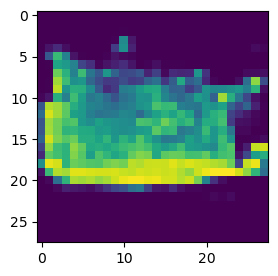

In [96]:
# create new image and from intent input

model = load_model('cgan_generator.h5')

image_gen = model.predict([noise_input, np.array(cluster)])
# new_image = generator.predict(edge_img_4dims)

plt.figure(figsize=(3,3))
plt.imshow(image_gen.reshape((28,28)))
plt.show()

The ouput show that the model complete convert it to original image but not generate the new one.

# TensorBoard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs